In [1]:
# Check for GPU availability
!nvidia-smi


Fri Dec  5 16:57:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!sudo apt-get update
!sudo apt-get install -y cuda-toolkit-11-8


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,286 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:13 https://ppa.launchpadcontent.net/gr

In [3]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [4]:
import numpy as np
import time


In [26]:
%%writefile cpu_reduction.cpp
#include <iostream>
#include <vector>
#include <chrono>

float cpu_reduce(const std::vector<float>& data) {
    float sum = 0.0f;
    for (float v : data) sum += v;
    return sum;
}

int main() {
    int N = 1 << 24;
    std::vector<float> data(N, 1.0f);

    auto start = std::chrono::high_resolution_clock::now();
    float result = cpu_reduce(data);
    auto end = std::chrono::high_resolution_clock::now();

    double ms = std::chrono::duration<double, std::milli>(end - start).count();
    std::cout << "CPU sum: " << result << ", Time: " << ms << " ms\n";
}


Overwriting cpu_reduction.cpp


In [45]:
!g++ cpu_reduction.cpp -o cpu_reduce
!./cpu_reduce


CPU sum: 1.67772e+07, Time: 206.904 ms


In [40]:
%%writefile reduction.cu
#include <stdio.h>
#include <cuda.h>

#define N (1 << 24)  // 16M elements


#define CUDA_CHECK(err) { gpuAssert((err), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line)
{
    if (code != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s %s %d\n",
                cudaGetErrorString(code), file, line);
        exit(code);
    }
}


// Version 1
__global__ void reduce_v1(float *g_idata, float *g_odata) {
    extern __shared__ float sdata[];
    unsigned int tid = threadIdx.x;
    unsigned int i = blockIdx.x * blockDim.x + threadIdx.x;

    sdata[tid] = g_idata[i];
    __syncthreads();

    for (unsigned int s = blockDim.x/2; s > 0; s >>= 1) {
        if (tid < s)
            sdata[tid] += sdata[tid + s];
        __syncthreads();
    }

    if (tid == 0)
        g_odata[blockIdx.x] = sdata[0];
}

// Version 2
__global__ void reduce_v2(float *g_idata, float *g_odata) {
    extern __shared__ float sdata[];
    unsigned int tid = threadIdx.x;
    unsigned int idx = blockIdx.x * (blockDim.x * 2) + threadIdx.x;

    sdata[tid] = g_idata[idx] + g_idata[idx + blockDim.x];
    __syncthreads();

    for (unsigned int s = blockDim.x/2; s > 0; s >>= 1) {
        if (tid < s)
            sdata[tid] += sdata[tid + s];
        __syncthreads();
    }

    if (tid == 0)
        g_odata[blockIdx.x] = sdata[0];
}


// Version 3

__global__ void reduce_v3(float *g_idata, float *g_odata) {
    extern __shared__ float sdata[];
    unsigned int tid = threadIdx.x;
    unsigned int idx = blockIdx.x * (blockDim.x * 8) + threadIdx.x;

    float sum = 0.0f;
    #pragma unroll
    for (int i = 0; i < 8; i++)
        sum += g_idata[idx + i * blockDim.x];

    sdata[tid] = sum;
    __syncthreads();

    for (unsigned int s = blockDim.x/2; s > 0; s >>= 1) {
        if (tid < s)
            sdata[tid] += sdata[tid + s];
        __syncthreads();
    }

    if (tid == 0)
        g_odata[blockIdx.x] = sdata[0];
}


// Version 4

__inline__ __device__ float warp_reduce(float val) {
    for (int offset = warpSize/2; offset > 0; offset >>= 1) {
        val += __shfl_down_sync(0xffffffff, val, offset);
    }
    return val;
}

__global__ void reduce_v4(float *g_idata, float *g_odata) {
    unsigned int tid = threadIdx.x;
    unsigned int idx = blockIdx.x * blockDim.x + tid;

    float val = g_idata[idx];

    // Step 1: reduce within warp
    val = warp_reduce(val);

    __shared__ float warp_sums[32];  // supports up to 1024 threads (32 warps)

    // Step 2: each warp writes its partial sum
    if ((tid & 31) == 0)
        warp_sums[tid >> 5] = val;

    __syncthreads();

    // Step 3: first warp reduces warp_sums[]
    if (tid < 32) {
        float warp_val = warp_sums[tid];
        warp_val = warp_reduce(warp_val);

        if (tid == 0)
            g_odata[blockIdx.x] = warp_val;
    }
}


// Helper: Sum partial blocks on CPU

float final_cpu_sum(float *h_out, int count) {
    float total = 0;
    for (int i = 0; i < count; i++)
        total += h_out[i];
    return total;
}


// Timing wrapper

float run_kernel(void (*kernel)(float*, float*),
                 const char* name,
                 int blocks,
                 int blockSize,
                 int sharedMem,
                 float *d_in,
                 float *d_out,
                 float *h_out)
{
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaMemset(d_out, 0, blocks * sizeof(float));

    cudaEventRecord(start);
    kernel<<<blocks, blockSize, sharedMem>>>(d_in, d_out);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);

    CUDA_CHECK(cudaMemcpy(h_out, d_out, blocks * sizeof(float), cudaMemcpyDeviceToHost));
    float sum = final_cpu_sum(h_out, blocks);

    printf("%s: blocks=%d blockSize=%d kernel_time=%f ms final_sum=%f (expected %d)\n",
           name, blocks, blockSize, ms, sum, N);

    return ms;
}


int main() {
    printf("Corrected CUDA reduction benchmark (N = %d elements)\n", N);

    int blockSize = 1024;

    int blocks_v1 = N / blockSize;
    int blocks_v2 = N / (blockSize * 2);
    int blocks_v3 = N / (blockSize * 8);
    int blocks_v4 = N / blockSize;

    float *d_in, *d_out;
    CUDA_CHECK(cudaMalloc(&d_in, N * sizeof(float)));
    CUDA_CHECK(cudaMalloc(&d_out, blocks_v1 * sizeof(float)));

    float *h_in = (float*)malloc(N * sizeof(float));
    float *h_out = (float*)malloc(blocks_v1 * sizeof(float));
    for (int i = 0; i < N; i++) h_in[i] = 1.0f;

    CUDA_CHECK(cudaMemcpy(d_in, h_in, N * sizeof(float), cudaMemcpyHostToDevice));

    run_kernel((void (*)(float*, float*))reduce_v1, "V1 Naive",
               blocks_v1, blockSize, blockSize * sizeof(float),
               d_in, d_out, h_out);

    run_kernel((void (*)(float*, float*))reduce_v2, "V2 2x load",
               blocks_v2, blockSize, blockSize * sizeof(float),
               d_in, d_out, h_out);

    run_kernel((void (*)(float*, float*))reduce_v3, "V3 unroll8",
               blocks_v3, blockSize, blockSize * sizeof(float),
               d_in, d_out, h_out);

    run_kernel((void (*)(float*, float*))reduce_v4, "V4 warp",
               blocks_v4, blockSize, 0,
               d_in, d_out, h_out);

    free(h_in);
    free(h_out);
    cudaFree(d_in);
    cudaFree(d_out);

    return 0;
}


Overwriting reduction.cu


In [41]:
!nvcc reduction.cu -o reduction -O3 -arch=sm_75 --generate-code=arch=compute_75,code=sm_75


In [42]:
output = !./reduction
print("\n".join(output))


Corrected CUDA reduction benchmark (N = 16777216 elements)
V1 Naive: blocks=16384 blockSize=1024 kernel_time=2.592768 ms final_sum=16777216.000000 (expected 16777216)
V2 2x load: blocks=8192 blockSize=1024 kernel_time=1.320288 ms final_sum=16777216.000000 (expected 16777216)
V3 unroll8: blocks=2048 blockSize=1024 kernel_time=0.440288 ms final_sum=16777216.000000 (expected 16777216)
V4 warp: blocks=16384 blockSize=1024 kernel_time=0.993344 ms final_sum=16777216.000000 (expected 16777216)


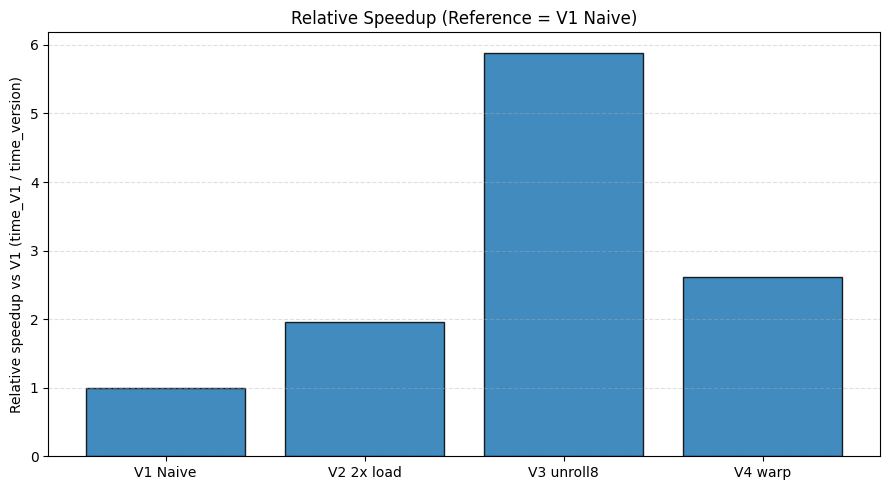

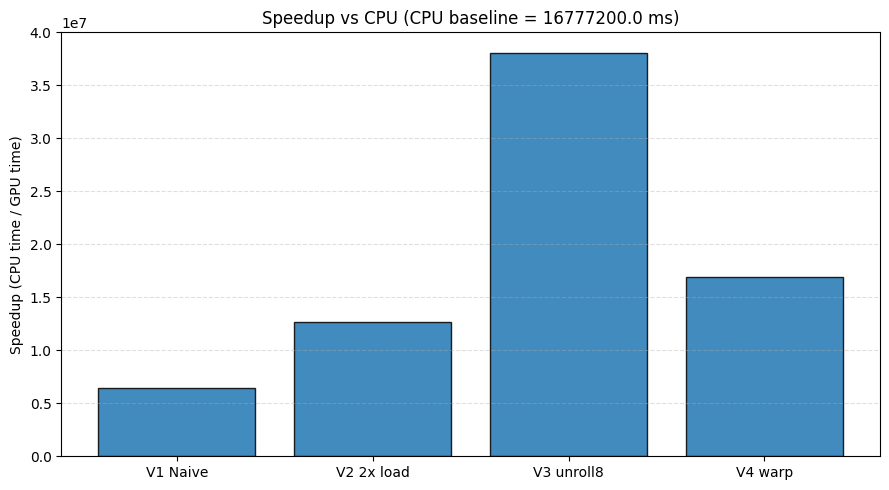

In [46]:
import matplotlib.pyplot as plt
import numpy as np

CPU_TIME_MS =  1.67772e+07
gpu_times = {
    "V1 Naive": 2.592768,
    "V2 2x load": 1.320288,
    "V3 unroll8": 0.440288,
    "V4 warp": 0.993344
}

versions = list(gpu_times.keys())
times = np.array([gpu_times[v] for v in versions])
if CPU_TIME_MS is not None:
    speedups_cpu = CPU_TIME_MS / times
else:
    speedups_cpu = None
v1_time = gpu_times["V1 Naive"]
relative_vs_v1 = v1_time / times

plt.figure(figsize=(9,5))
plt.bar(versions, relative_vs_v1, edgecolor='k', alpha=0.85)
plt.ylabel("Relative speedup vs V1 (time_V1 / time_version)")
plt.title("Relative Speedup (Reference = V1 Naive)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

if speedups_cpu is not None:
    plt.figure(figsize=(9,5))
    plt.bar(versions, speedups_cpu, edgecolor='k', alpha=0.85)
    plt.ylabel("Speedup (CPU time / GPU time)")
    plt.title(f"Speedup vs CPU (CPU baseline = {CPU_TIME_MS} ms)")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("Done")

